In [1]:
import ffn 
from empyrical import alpha_beta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

/home/luuk/anaconda3/lib/python3.8/site-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [ ]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [15]:
%matplotlib inline

In [3]:
fname = 'DATA 20201001_NOFS.xlsx'
df_INFO   = pd.read_excel(fname,sheet_name='INFO')

In [4]:
df_PRICES = pd.read_excel(fname,sheet_name='PRICES')
colnames  = df_PRICES.columns.values
colnames[0] = 'Date'
df_PRICES.columns = colnames
df_SIZES  = pd.read_excel(fname,sheet_name='SIZE')
colnames  = df_SIZES.columns.values
colnames[0] = 'Date'
df_SIZES.columns = colnames
df_PtB    = pd.read_excel(fname,sheet_name='PRICE TO BOOK')
colnames  = df_PtB.columns.values
colnames[0] = 'Date'
df_PtB.columns = colnames
df_turnover    = pd.read_excel(fname,sheet_name='TURNOVER')
colnames  = df_turnover.columns.values
colnames[0] = 'Date'
df_turnover.columns = colnames

df_PRICES['Date'] = pd.to_datetime(df_PRICES['Date'])
df_SIZES['Date']  = pd.to_datetime(df_SIZES['Date'])
df_PtB['Date']    = pd.to_datetime(df_PtB['Date'])
df_turnover['Date']    = pd.to_datetime(df_turnover['Date'])

df_PRICES = df_PRICES.set_index('Date')
df_SIZES = df_SIZES.set_index('Date')
df_PtB = df_PtB.set_index('Date')
df_turnover = df_turnover.set_index('Date')

In [5]:
df_turnover = df_turnover.iloc[1:,:]

In [6]:
# example
df_PRICES.iloc[:3,:6]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2018-12-31,100.00000,100.000000,100.00000,100.00000,100.000000,100.00000
2019-01-02,100.41382,101.683780,99.94125,99.72475,99.971680,99.04486
2019-01-03,100.11307,98.434883,100.88558,99.10764,95.307976,92.87219


In [7]:
# Step 1: Convert prices into returns
Returns = np.log(df_PRICES / np.roll(df_PRICES.values,1,axis=0))
Returns = Returns.iloc[1:]
Returns.iloc[:3,:6]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2019-01-02,0.004130,0.016698,-0.000588,-0.002756,-0.000283,-0.009597
2019-01-03,-0.003000,-0.032473,0.009404,-0.006207,-0.047773,-0.064349
2019-01-04,-0.003616,0.028332,0.015439,0.039607,0.054749,0.052771


In [8]:
Returns_60 = Returns.iloc[-60:]
#Returns_60['MARKET'] = Returns_60.mean(axis=1)

In [9]:
df_turnover = df_turnover.reindex(Returns.index)

In [10]:
excess_return = (Returns.T- Returns.mean(axis=1).values).T

In [11]:
excess_return.mean(axis=0)

BT.A-GB   -0.002134
CCL-GB    -0.003270
MKS-GB    -0.002171
BARC-GB   -0.001212
ITRK-GB    0.000374
             ...   
NEXI-IT    0.002051
TRN-GB    -0.000284
BCVN-CH    0.000496
PRX-NL     0.000423
FDJ-FR     0.001915
Length: 600, dtype: float64

In [12]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = df_turnover.mean(axis=0)
y =100*excess_return.mean(axis=0).abs()
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9063
Date:                Mon, 12 Oct 2020   Prob (F-statistic):              0.341
Time:                        10:57:43   Log-Likelihood:                 717.38
No. Observations:                 600   AIC:                            -1431.
Df Residuals:                     598   BIC:                            -1422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0853      0.004     23.020      0.0

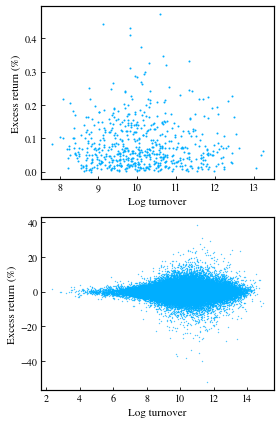

In [16]:
plt.figure(figsize=(4,6))
plt.subplot(211)
plt.scatter((np.log(df_turnover.mean(axis=0))),100*excess_return.mean(axis=0).abs(),s=1)
plt.xlabel('Log turnover',size=11)
plt.ylabel('Excess return (%)',size=11)
plt.tight_layout()
#plt.savefig('mean_volume_turnover.pdf')
plt.subplot(212)
plt.scatter(np.log(df_turnover.values.flatten()),100*excess_return.values.flatten(),s=0.1)
plt.xlabel('Log turnover',size=11)
plt.ylabel('Excess return (%)',size=11)
plt.tight_layout()


plt.savefig('turnover_excessret.png',dpi=100)

In [13]:
df_INFO=df_INFO.set_index('CODE')

In [14]:
a=df_INFO#
a['weight']=0

In [15]:
a.loc[df_turnover.mean(axis=0).sort_values().iloc[:100].index,'weight']=1/100

In [16]:
a.to_excel('week4.xlsx')

In [17]:
a['weight']

CODE
BT.A-GB    0.00
CCL-GB     0.00
MKS-GB     0.00
BARC-GB    0.00
ITRK-GB    0.00
           ... 
NEXI-IT    0.00
TRN-GB     0.01
BCVN-CH    0.00
PRX-NL     0.00
FDJ-FR     0.01
Name: weight, Length: 600, dtype: float64

In [44]:
Returns

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB,NXT-GB,UDG-GB,KGF-GB,ITV-GB,...,NDA.SE-SE,KBX-DE,ALC-CH,PHNX-GB,ADE-NO,NEXI-IT,TRN-GB,BCVN-CH,PRX-NL,FDJ-FR
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.004130,0.016698,-0.000588,-0.002756,-0.000283,-0.009597,0.041733,0.003691,0.004341,-0.003018,...,0.022264,0.004695,NaN,0.001669,NaN,NaN,NaN,0.000000,NaN,NaN
2019-01-03,-0.003000,-0.032473,0.009404,-0.006207,-0.047773,-0.064349,0.037166,-0.006747,0.010351,0.000179,...,-0.002318,-0.016981,NaN,-0.018534,NaN,NaN,NaN,0.035697,NaN,NaN
2019-01-04,-0.003616,0.028332,0.015439,0.039607,0.054749,0.052771,0.036905,0.025267,0.023343,0.016638,...,0.042804,0.051325,NaN,0.033208,NaN,NaN,NaN,-0.009815,NaN,NaN
2019-01-07,0.001744,0.028717,0.028805,0.001280,0.007879,0.000396,0.020650,0.001675,0.022167,-0.003948,...,-0.006864,0.008041,NaN,-0.002005,NaN,NaN,NaN,-0.001493,NaN,NaN
2019-01-08,-0.030720,0.021112,0.053051,0.011074,0.015819,0.020166,0.050052,0.000557,0.018690,0.040094,...,0.008050,-0.000243,NaN,0.023633,NaN,NaN,NaN,0.008516,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-25,-0.012131,0.045316,-0.032659,-0.013293,0.005438,0.008496,-0.012369,0.038863,0.018408,0.029776,...,0.000529,-0.002836,0.003579,0.000726,-0.004878,-0.010390,0.016923,-0.010035,-0.017560,0.009533
2020-09-28,0.022143,0.059838,0.066559,0.076573,0.008176,0.033744,0.018217,0.003265,-0.001700,0.060309,...,0.030749,0.021172,0.014733,0.037164,0.038197,0.005060,0.082317,0.003717,0.001796,0.028065
2020-09-29,-0.032064,-0.009299,-0.040915,-0.015118,0.001027,-0.002712,-0.023248,0.004930,0.000725,-0.014415,...,-0.002585,-0.005176,-0.004548,-0.023427,0.014125,0.001187,-0.038257,-0.016017,-0.009786,-0.023648
